# **Loading Dependencies**

In [7]:
pip install pandas numpy matplotlib seaborn pillow torch torchvision scikit-plot scikit-learn

In [8]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, vit_b_16
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_fscore_support
)
# from scikitplot.metrics import plot_roc

In [9]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TORCH_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224)
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
print(CFG.DEVICE)

cuda


In [11]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [12]:
seed_everything(CFG.SEED)

In [13]:
print('Package versions:')
print('*'*26)
print(f'pandas \t\t - {pd.__version__}')
print(f'numpy \t\t - {np.__version__}')
print(f'sklearn \t - {sklearn.__version__}')
print(f'torch \t\t - {torch.__version__}')
print(f'torchvision \t - {torchvision.__version__}')


Package versions:
**************************
pandas 		 - 2.2.2
numpy 		 - 1.26.4
sklearn 	 - 1.5.2
torch 		 - 2.4.1+cu121
torchvision 	 - 0.19.1+cu121


In [37]:
!pip install timm
import torch
import torch.nn as nn
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.1 MB/s eta 0:00:00


# **Loading Data**

In [14]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)


# DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
# TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
# TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/


DATASET_PATH = "/content/drive/MyDrive/skin cancer /skin cancer/data/"

TRAIN_PATH_benign = '/content/drive/MyDrive/skin cancer /skin cancer/data/train/benign'
TRAIN_PATH_malignant = '/content/drive/MyDrive/skin cancer /skin cancer/data/train/malignant'


TEST_PATH_benign = '/content/drive/MyDrive/skin cancer /skin cancer/data/test/benign'
TEST_PATH_malignant = '/content/drive/MyDrive/skin cancer /skin cancer/data/test/malignant'

Mounted at /content/drive


In [15]:
# Generate a summary of the dataset

import os

print('DATASET SUMMARY')

print('========================\n')
for dirpath, dirnames, filenames in os.walk(TEST_PATH_benign):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 0 directories and 360 images in /content/drive/MyDrive/skin cancer /skin cancer/data/test/benign



In [16]:
%%time

import glob
train_images_benign= glob.glob(f"{TRAIN_PATH_benign}**/*.jpg")
train_images_malignant= glob.glob(f"{TRAIN_PATH_malignant}**/*.jpg")

test_images_benign= glob.glob(f"{TEST_PATH_benign}**/*.jpg")
test_images_malignant= glob.glob(f"{TEST_PATH_malignant}**/*.jpg")



CPU times: user 15.2 ms, sys: 1.12 ms, total: 16.3 ms
Wall time: 295 ms


In [17]:
# Get train & test set sizes
train_size = len(train_images_benign)+len(train_images_malignant)
test_size = len(test_images_benign)+len(test_images_malignant)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2647
test samples count:		660
TOTAL:				3307


In [18]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [19]:
train_images=np.concatenate((train_images_benign,train_images_malignant),axis=0)
test_images=np.concatenate((test_images_benign,test_images_malignant),axis=0)

In [20]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))

test_df = build_df(test_images, generate_labels(test_images))

In [21]:

# View first 5 samples in the training set
train_df.head(5)

image_path      label  label_encoded
0  /content/drive/MyDrive/skin cancer /skin cance...  malignant              0
1  /content/drive/MyDrive/skin cancer /skin cance...     benign              1
2  /content/drive/MyDrive/skin cancer /skin cance...     benign              1
3  /content/drive/MyDrive/skin cancer /skin cance...     benign              1
4  /content/drive/MyDrive/skin cancer /skin cance...     benign              1

In [22]:
transform = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),  # Converts the image to [0, 1] range and also normalizes it to a float32 tensor
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # No change here, just for clarity
])

def _load(image_path):
    # Load image using PIL
    image = Image.open(image_path).convert('RGB')

    # Apply transforms (resize and normalize)
    image = transform(image)

    # Return the image as a torch tensor
    return image

def view_sample(image_tensor, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    # Convert tensor to numpy image for visualization
    image = image_tensor.permute(1, 2, 0).numpy()  # Rearrange tensor dimensions for plotting

    if color_map == 'rgb':
        plt.imshow(image)
    else:
        plt.imshow(image.mean(axis=2), cmap=color_map)  # Grayscale view

    plt.title(f'Label: {label}', fontsize=16)
    plt.show()


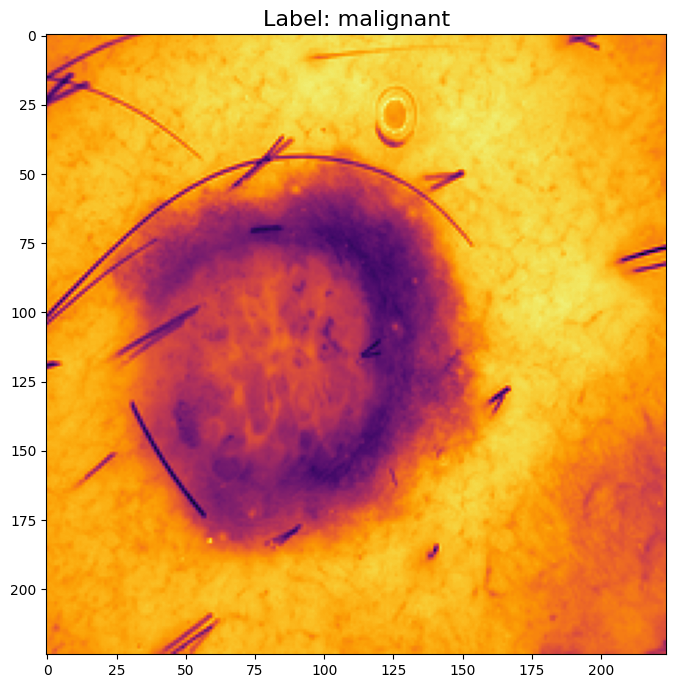

In [23]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')


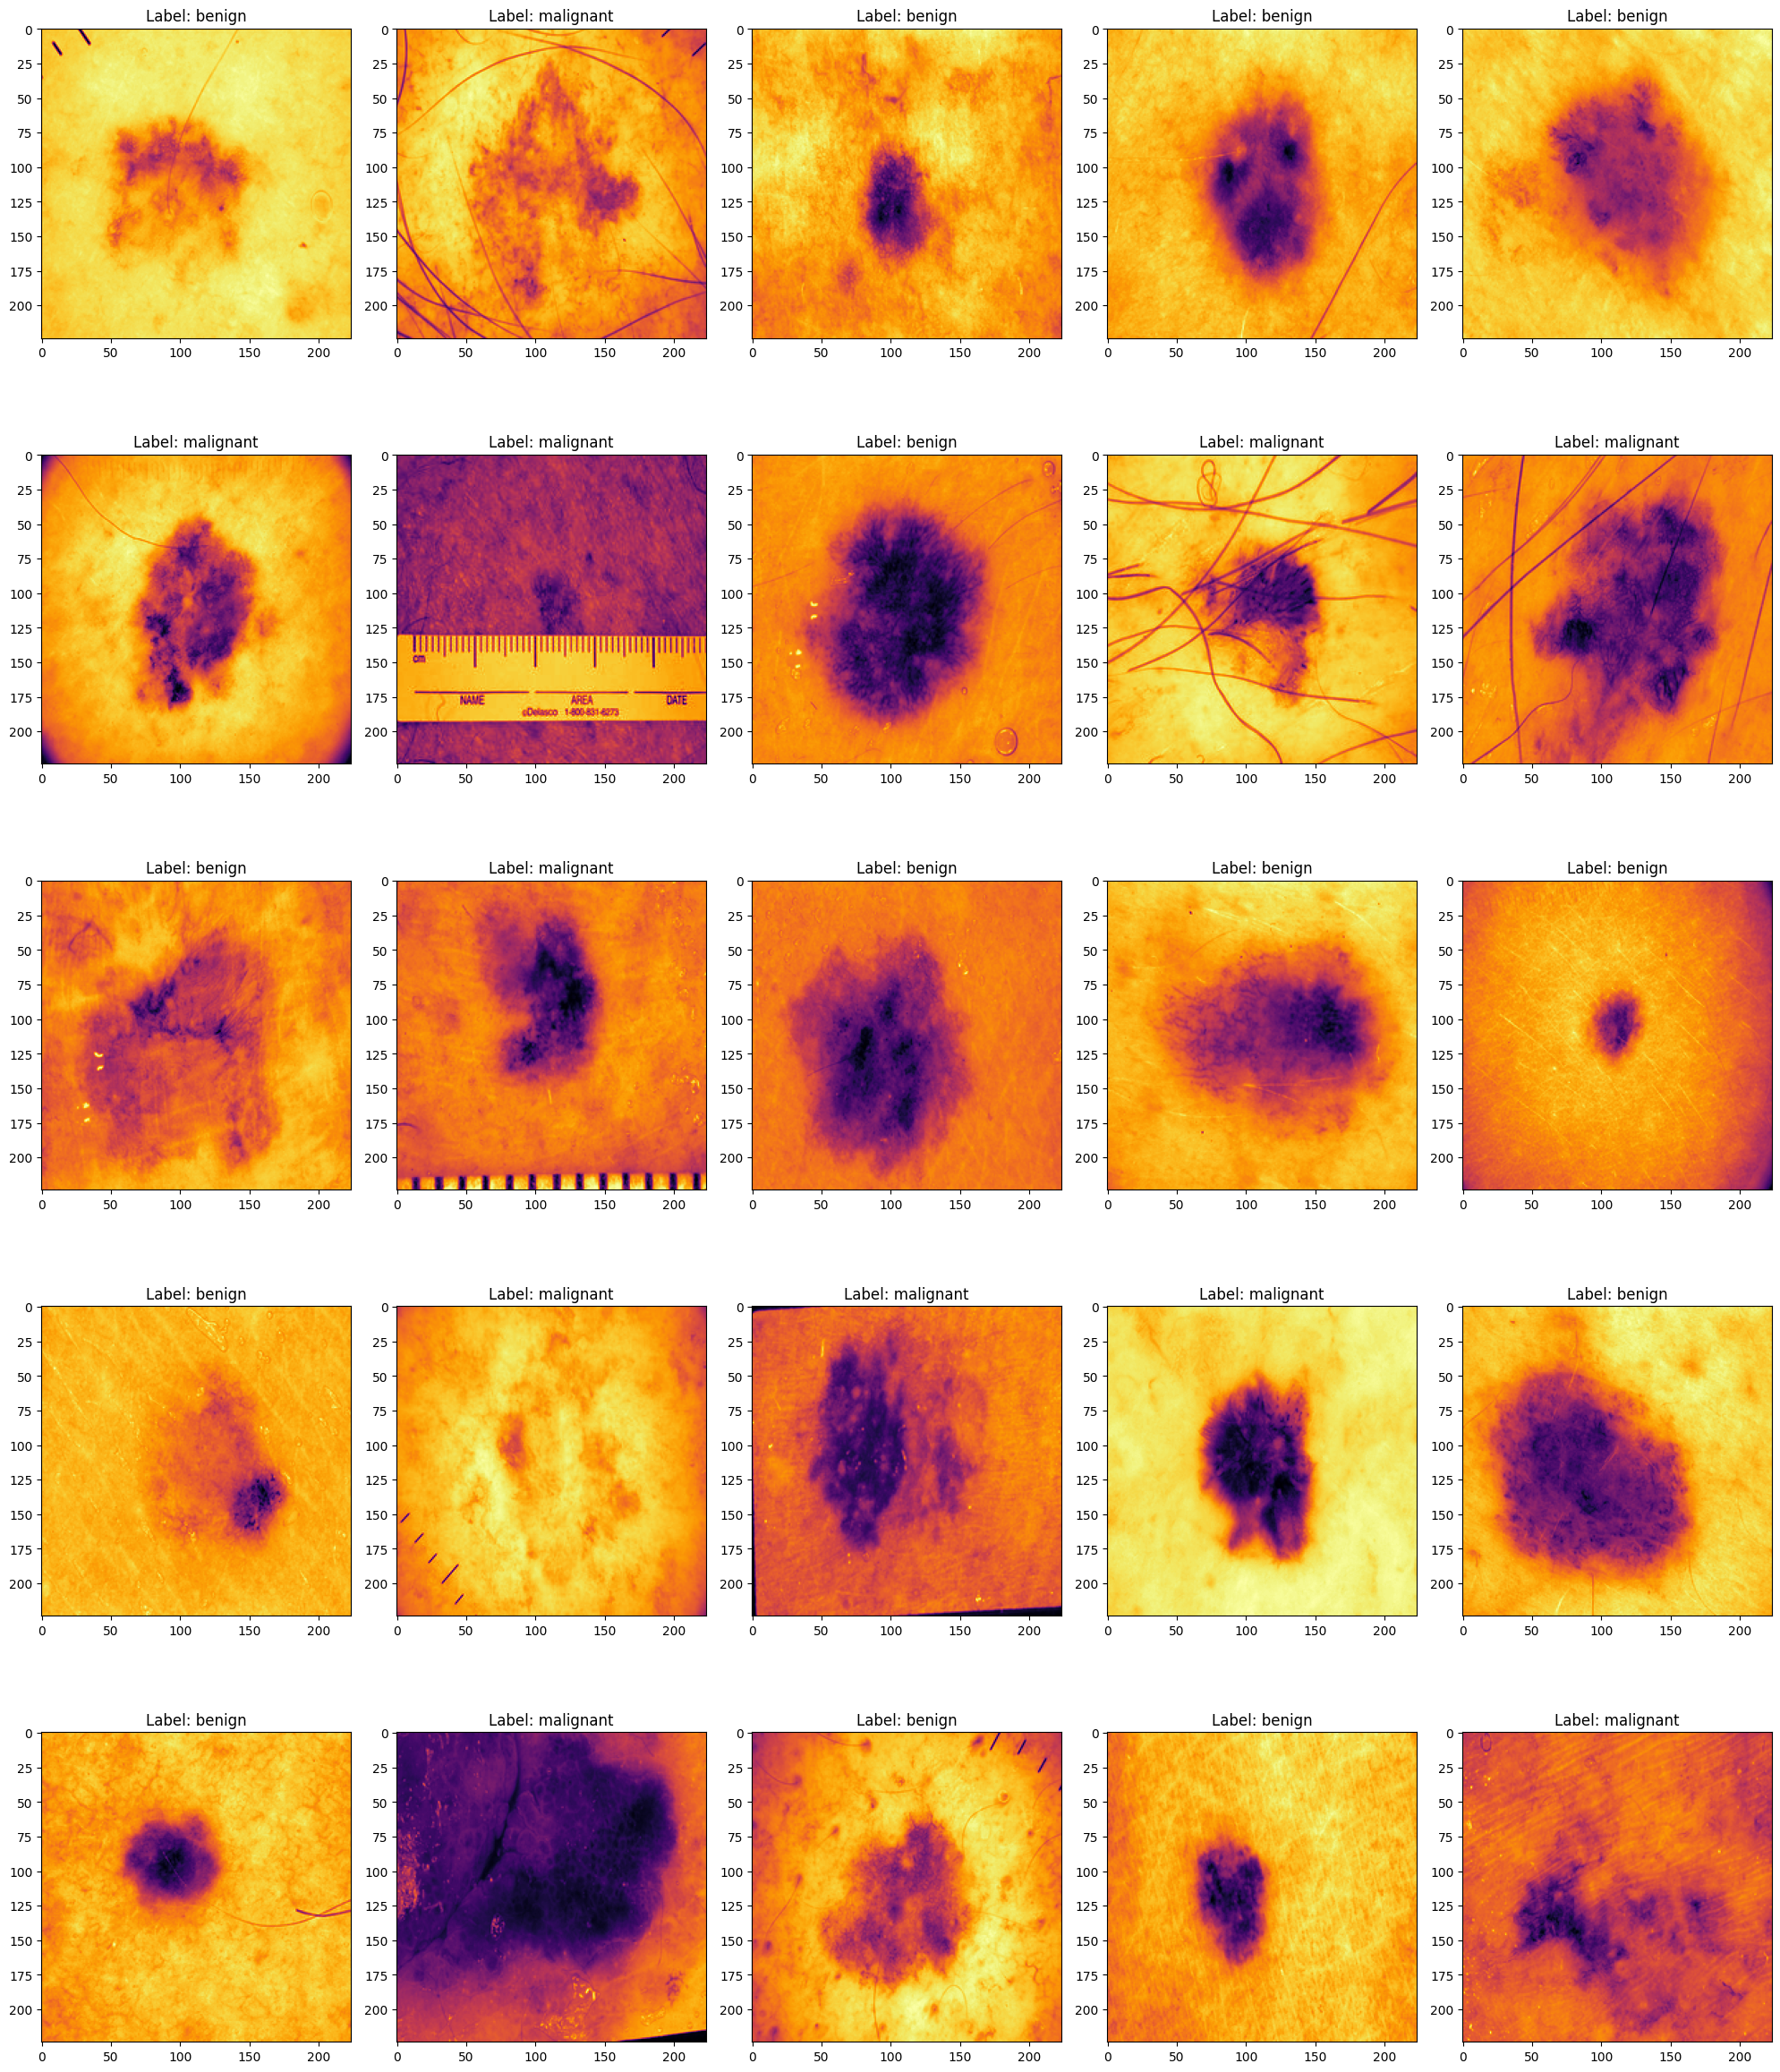

In [24]:

def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count // 5
    if count % 5 > 0:
        rows += 1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column + 1)
        plt.title(f'Label: {df.label[_]}')

        # Load the image using the sample_loader
        image = sample_loader(df.image_path[_])

        if color_map == 'rgb':
            # Convert tensor to numpy array and transpose to (H, W, C)
            image = image.permute(1, 2, 0).numpy()
            plt.imshow(image)
        else:
            # Convert to grayscale if needed
            grayscale_image = transforms.functional.rgb_to_grayscale(image)
            grayscale_image = grayscale_image.squeeze().numpy()  # Remove channel dimension
            plt.imshow(grayscale_image, cmap=color_map)

    plt.tight_layout()
    plt.show()


view_multiple_samples(train_df, _load,
                      count=25, color_map='inferno',
                      fig_size=(20, 24))

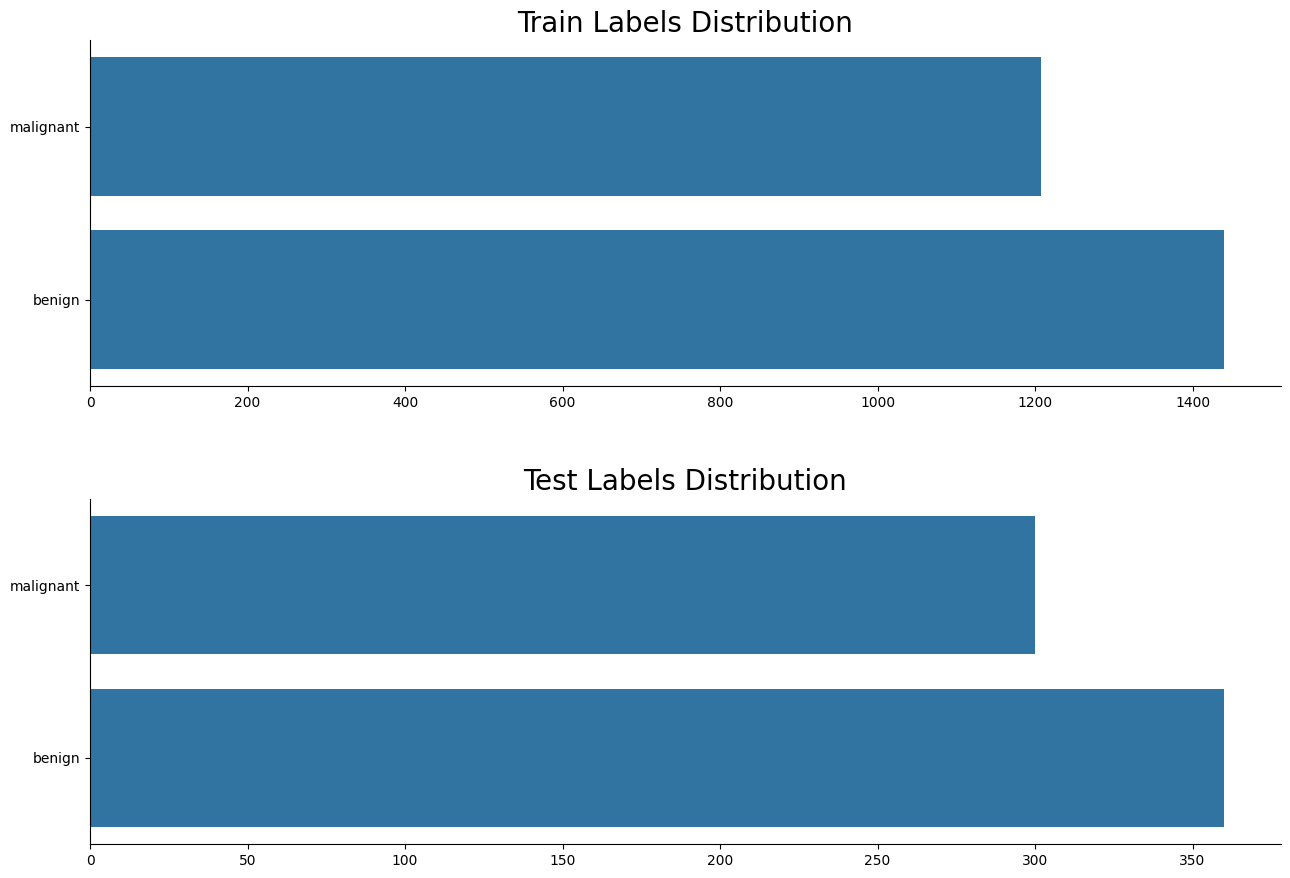

In [25]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

In [26]:
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index,
                                                        train_df.label_encoded,
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [27]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2249, 3), (398, 3))

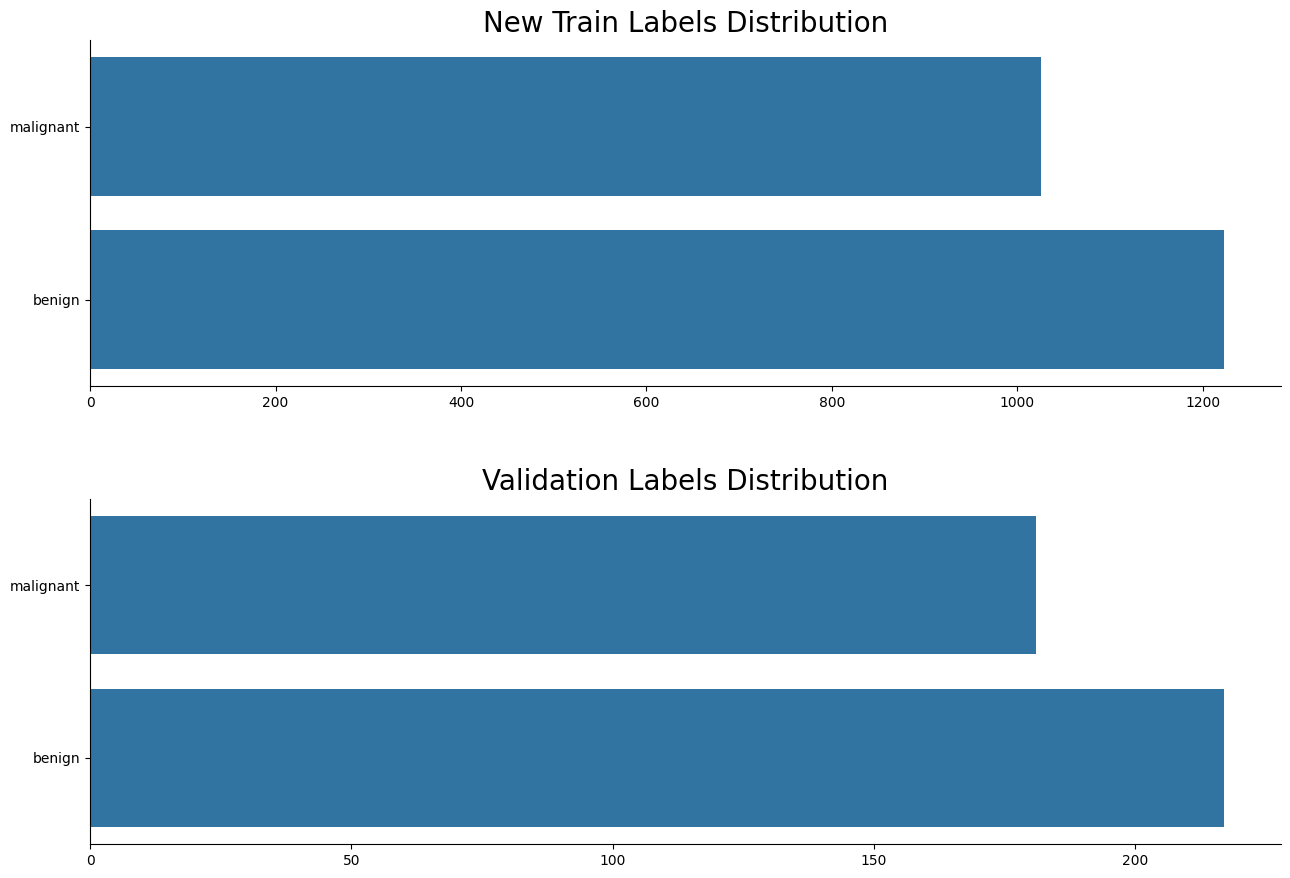

In [28]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Labels Distribution
ax1.set_title('New Train Labels Distribution', fontsize=20)
train_new_distribution = train_new_df['label'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

In [29]:
augmentation_layer = transforms.Compose([
    # Randomly flip horizontally and vertically
    transforms.RandomHorizontalFlip(p=0.5),  # Probability of 0.5 for horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Probability of 0.5 for vertical flip

    # Random zoom (simulating by random resize followed by random crop)
    transforms.RandomResizedCrop(size=(CFG.HEIGHT, CFG.WIDTH), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    # Convert to Tensor after augmentations
    transforms.ToTensor()
])

def apply_augmentations(image_path):
    # Load image using PIL
    image = Image.open(image_path).convert('RGB')

    # Apply the augmentation transformations
    augmented_image = augmentation_layer(image)

    return augmented_image

In [30]:
def tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0).numpy()  # Change the order of dimensions for plotting (H, W, C)
    image = image.clip(0, 1)  # Clip to valid range [0,1]
    return image

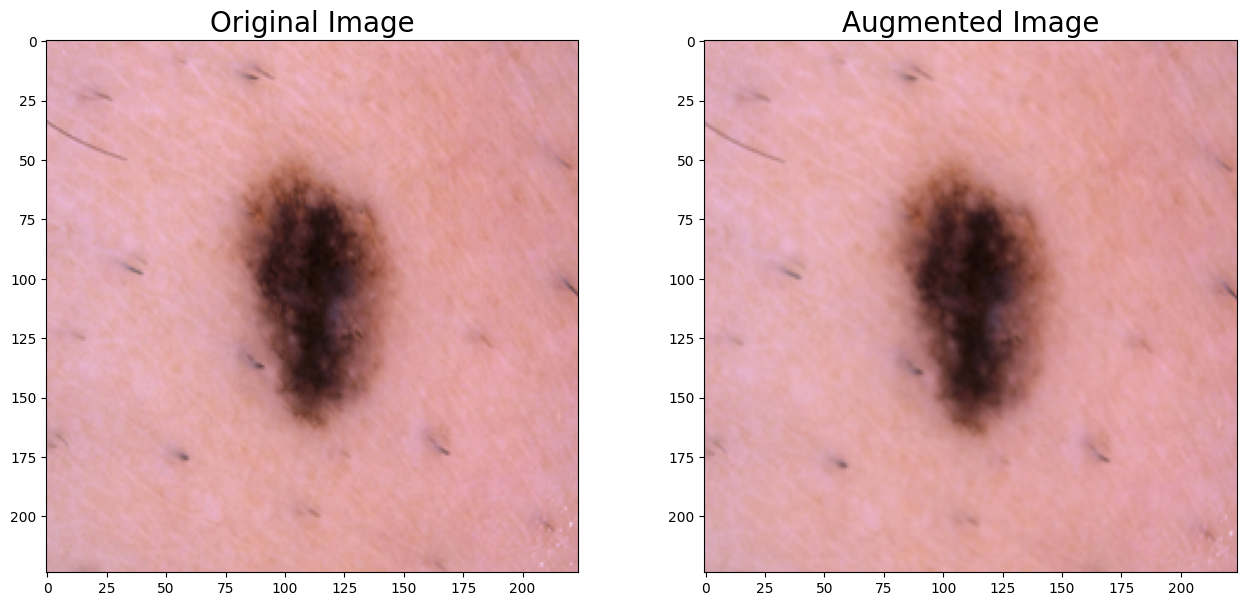

In [31]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample image and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# Apply augmentations to the sample image
augmented_image = apply_augmentations(train_df.image_path[idx])

# Plotting the original and augmented images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(tensor_to_image(sample_image), cmap='inferno')

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(tensor_to_image(augmented_image), cmap='inferno')

plt.show()

In [32]:
class CustomDataset(Dataset):
    def __init__(self, df, load_function, augment=False):
        self.image_paths = df.image_path
        self.labels = df.label_encoded.tolist()  # Use integer labels directly
        self.load_function = load_function
        self.augment = augment

        # Define augmentation layer using PyTorch transforms
        self.augmentation_layer = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomResizedCrop(size=(CFG.HEIGHT, CFG.WIDTH), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
        ])

        # Define a separate transformation for non-augmented images
        self.base_transform = transforms.Compose([
            transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = self.load_function(self.image_paths[idx])

        # Apply augmentations if augment is True
        if self.augment:
            image = self.augmentation_layer(image)
            image = transforms.ToTensor()(image)
        else:
            image = self.base_transform(image)

        label = self.labels[idx]

        return image, label

# Define the image loading function (PIL image loading)
def load_function(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB
    return image

# The create_pipeline function remains unchanged

# Create a PyTorch data pipeline using DataLoader
def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using PyTorch DataLoader given a Pandas DataFrame and image loading function.

    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> Not used in PyTorch, placeholder for compatibility
        - prefetch: (bool) -> Not used in PyTorch, placeholder for compatibility

    @returns
        - dataset_loader: (torch.utils.data.DataLoader) -> DataLoader for training a PyTorch model
    '''
    # Create a custom dataset
    dataset = CustomDataset(df, load_function, augment=augment)

    # Create a DataLoader to batch and shuffle data
    dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)

    return dataset_loader


In [33]:
# Generate Train Input Pipeline
train_ds = create_pipeline(
    train_new_df, _load, augment=True,
    batch_size=CFG.BATCH_SIZE,
    shuffle=True  # Shuffling is True for training to ensure randomness
)

# Generate Validation Input Pipeline
val_ds = create_pipeline(
    val_df, _load, augment=False,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False  # No shuffling for validation
)

# Generate Test Input Pipeline
test_ds = create_pipeline(
    test_df, _load, augment=False,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False  # No shuffling for testing
)


In [34]:
train_loader = create_pipeline(train_df, load_function, augment=True, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = create_pipeline(val_df, load_function, augment=False, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = create_pipeline(test_df, load_function, augment=False, batch_size=CFG.BATCH_SIZE, shuffle=True)

In [35]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

Validation Input Data Pipeline:

Test Input Data Pipeline:



# **CNN**

In [68]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define the CNN layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=CFG.CHANNELS, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(8 * (CFG.HEIGHT // 4) * (CFG.WIDTH // 4), 128),  # Adjusting to flattened dimensions after conv layers
            nn.ReLU(),
            nn.Linear(128, 2),  # Output layer with 2 classes (binary classification)
            nn.Sigmoid()  # Sigmoid activation function for binary output
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model_cnn = CNNModel().to(CFG.DEVICE)


In [ ]:
pip install torchinfo torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=df9c7a3c5ce88cb810abca453984dee8a2923a0234918a685c5d3302f8a14081
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchinfo import summary

# Assuming model_cnn is your model
summary(model_cnn, input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.HEIGHT, CFG.WIDTH))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 2]                   --
├─Sequential: 1-1                        [32, 8, 56, 56]           --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─ReLU: 2-2                         [32, 16, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 16, 224, 224]        2,320
│    └─ReLU: 2-4                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 16, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 8, 112, 112]         1,160
│    └─ReLU: 2-7                         [32, 8, 112, 112]         --
│    └─Conv2d: 2-8                       [32, 8, 112, 112]         584
│    └─ReLU: 2-9                         [32, 8, 112, 112]         --
│    └─MaxPool2d: 2-10                   [32, 8, 56, 56]           --
├─Sequential: 1-2                        [32, 2]                   --
│    └─

In [ ]:
from torchviz import make_dot

# Create a dummy input tensor with the correct shape
dummy_input = torch.randn(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.HEIGHT, CFG.WIDTH).to(CFG.DEVICE)

# Perform a forward pass to create a graph
output = model_cnn(dummy_input)

# Visualize the graph
dot = make_dot(output, params=dict(model_cnn.named_parameters()))

# Save the plot as a .png file or display it
dot.render("cnn_model_visualization", format="png")

# To display the plot in a notebook or directly, you can do this
dot.view()


'cnn_model_visualization.pdf'

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0, restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model:
                    model.load_state_dict(self.best_model)


In [ ]:
pip install torch torchvision torchaudio

In [ ]:
# Define loss function and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

criterion = nn.BCEWithLogitsLoss()  # Binary CrossEntropy in PyTorch
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

# Callbacks
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
# Use CrossEntropyLoss for multi-class classification (works for binary too)
criterion = nn.CrossEntropyLoss()

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in range(20):
    print(f'Epoch {epoch+1}/{CFG.EPOCHS}')

    # Training phase
    model_cnn.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(CFG.DEVICE), labels.to(CFG.DEVICE)

        optimizer.zero_grad()

        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples

    print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Validation phase
    if val_loader:
        model_cnn.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(CFG.DEVICE), labels.to(CFG.DEVICE)

                outputs = model_cnn(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += (preds == labels).sum().item()
                val_total_samples += labels.size(0)

        val_loss = val_running_loss / val_total_samples
        val_acc = val_correct_preds / val_total_samples

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Step the scheduler
        reduce_lr.step(val_loss)

        # Check for early stopping
        # early_stopping(val_loss, model_cnn)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break

Epoch 1/20
Train Loss: 0.6839, Train Accuracy: 0.5419
Validation Loss: 0.6239, Validation Accuracy: 0.6288
Epoch 2/20
Train Loss: 0.6142, Train Accuracy: 0.6830
Validation Loss: 0.5450, Validation Accuracy: 0.7551
Epoch 3/20
Train Loss: 0.5364, Train Accuracy: 0.7683
Validation Loss: 0.5432, Validation Accuracy: 0.7500
Epoch 4/20
Train Loss: 0.5197, Train Accuracy: 0.7793
Validation Loss: 0.5130, Validation Accuracy: 0.7702
Epoch 5/20
Train Loss: 0.5110, Train Accuracy: 0.7884
Validation Loss: 0.4994, Validation Accuracy: 0.7980
Epoch 6/20
Train Loss: 0.4991, Train Accuracy: 0.7990
Validation Loss: 0.5031, Validation Accuracy: 0.7727
Epoch 7/20
Train Loss: 0.4927, Train Accuracy: 0.8020
Validation Loss: 0.4966, Validation Accuracy: 0.8030
Epoch 8/20
Train Loss: 0.5059, Train Accuracy: 0.7948
Validation Loss: 0.5128, Validation Accuracy: 0.7929
Epoch 9/20
Train Loss: 0.4874, Train Accuracy: 0.8111
Validation Loss: 0.4883, Validation Accuracy: 0.7980
Epoch 10/20
Train Loss: 0.5030, Train

# **Efficient Net**

In [43]:
import timm

# List available models in timm
available_models = timm.list_models(pretrained=True)
print(available_models)


['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [44]:



class EfficientNetV2Model(nn.Module):
    def __init__(self):
        super(EfficientNetV2Model, self).__init__()

        # Load EfficientNetV2 pre-trained on ImageNet
        self.efficientnet_v2 = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=True, num_classes=0)  # Exclude top layer

        # Freeze the EfficientNetV2 layers
        for param in self.efficientnet_v2.parameters():
            param.requires_grad = False

        # Additional layers
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(1792, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through EfficientNetV2
        x = self.efficientnet_v2(x)  # Already gives output of shape (batch_size, 1792)

        # Additional layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)  # Sigmoid for binary classification

        return x



# Instantiate the model
model_efficientnet_v2_pytorch = EfficientNetV2Model().to(CFG.DEVICE)

# Print summary of the model
print(model_efficientnet_v2_pytorch)


model.safetensors:   0%|          | 0.00/96.5M [00:00<?, ?B/s]

EfficientNetV2Model(
  (efficientnet_v2): EfficientNet(
    (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pwl): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
       

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(model_efficientnet_v2_pytorch.parameters(), lr=0.001)
reduce_lr = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}


for epoch in range(CFG.EPOCHS):
    print(f'Epoch {epoch+1}/{CFG.EPOCHS}')

    # Training phase
    model_efficientnet_v2_pytorch.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        # print(inputs.shape)
        optimizer.zero_grad()

        outputs = model_efficientnet_v2_pytorch(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples

    print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Validation phase
    if val_loader:
        model_efficientnet_v2_pytorch.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(CFG.DEVICE), labels.to(CFG.DEVICE)

                outputs = model_efficientnet_v2_pytorch(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += (preds == labels).sum().item()
                val_total_samples += labels.size(0)

        val_loss = val_running_loss / val_total_samples
        val_acc = val_correct_preds / val_total_samples

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)



Epoch 1/10
Train Loss: 0.5308, Train Accuracy: 0.7888
Validation Loss: 0.5060, Validation Accuracy: 0.7940


NameError: name 'reduce_lr' is not defined

# **Vision Transformer**

In [38]:

class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()

        # Load pre-trained ViT model with 'vit_base_patch16_224' architecture from timm
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)  # Exclude the classification head

        # Freeze the ViT model layers
        for param in self.vit.parameters():
            param.requires_grad = False

        # Add Dropout and Fully Connected layers
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(768, 128)  # 768 is the output size of the ViT model
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)  # 2 output classes for binary classification
        self.sigmoid = nn.Sigmoid()  # Use sigmoid for binary classification

    def forward(self, x):
        # Forward pass through ViT model
        x = self.vit(x)

        # Additional layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x
model_vit = ViTModel().to(CFG.DEVICE)

# Optimizer setup: Only optimize the new layers
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_vit.parameters()), lr=0.001
)

# Loss function for binary classification
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:

criterion = nn.CrossEntropyLoss()
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in range(CFG.EPOCHS):
    print(f'Epoch {epoch+1}/{CFG.EPOCHS}')
    # Training phase
    model_vit.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        optimizer.zero_grad()
        outputs = model_vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Validation phase
    if val_loader:
        model_vit.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_samples = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(CFG.DEVICE), labels.to(CFG.DEVICE)
                outputs = model_vit(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += (preds == labels).sum().item()
                val_total_samples += labels.size(0)
        val_loss = val_running_loss / val_total_samples
        val_acc = val_correct_preds / val_total_samples
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Step the scheduler
        # reduce_lr.step(val_loss)

        # Check for early stopping
        # early_stopping(val_loss, model_vit)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break


Epoch 1/20
Train Loss: 0.4942, Train Accuracy: 0.8180
Validation Loss: 0.4547, Validation Accuracy: 0.8535
Epoch 2/20
Train Loss: 0.4540, Train Accuracy: 0.8510
Validation Loss: 0.4506, Validation Accuracy: 0.8485
Epoch 3/20
Train Loss: 0.4393, Train Accuracy: 0.8699
Validation Loss: 0.4474, Validation Accuracy: 0.8561
Epoch 4/20
Train Loss: 0.4314, Train Accuracy: 0.8771
Validation Loss: 0.4303, Validation Accuracy: 0.8838
Epoch 5/20
Train Loss: 0.4301, Train Accuracy: 0.8817
Validation Loss: 0.4228, Validation Accuracy: 0.8914
Epoch 6/20
Train Loss: 0.4239, Train Accuracy: 0.8847
Validation Loss: 0.4245, Validation Accuracy: 0.8889
Epoch 7/20
Train Loss: 0.4210, Train Accuracy: 0.8859
Validation Loss: 0.4163, Validation Accuracy: 0.8990
Epoch 8/20
Train Loss: 0.4198, Train Accuracy: 0.8878
Validation Loss: 0.4147, Validation Accuracy: 0.9015
Epoch 9/20
Train Loss: 0.4204, Train Accuracy: 0.8878
Validation Loss: 0.4152, Validation Accuracy: 0.9091
Epoch 10/20
Train Loss: 0.4153, Train

# **Result Visualization**

In [74]:
import torch

model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/skin cancer /skin cancer/skin cancer/models/cnn_model.pth'))
model_efficientnet_v2_pytorch.load_state_dict(torch.load('/content/drive/MyDrive/skin cancer /skin cancer/skin cancer/models/efficientnet.pth'))
model_vit.load_state_dict(torch.load('/content/drive/MyDrive/skin cancer /skin cancer/skin cancer/models/vit_model.pth'))

<ipython-input-74-f3165973bfd1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/skin cancer /skin cancer/skin c

<All keys matched successfully>

In [70]:
unique_labels=np.unique(generate_labels(train_images))
print(unique_labels)

['benign' 'malignant']


In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score



def test_and_plot_confusion_matrix(model, data_loader, device, model_name):
    # Set the model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predictions

            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Testing Accuracy: {accuracy*100:.4f}')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return cm


Testing Accuracy: 88.7879


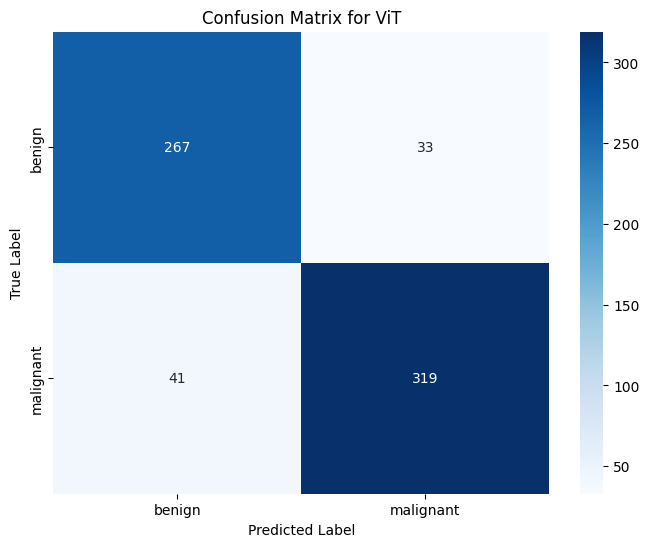

In [80]:
vit_cm=test_and_plot_confusion_matrix(model_vit, test_loader, CFG.DEVICE,'ViT')

Testing Accuracy: 81.3636


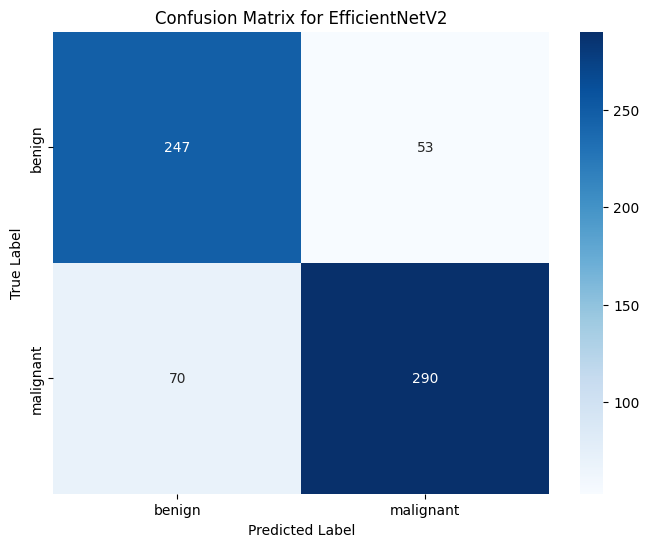

In [77]:
efficientnet_cm=test_and_plot_confusion_matrix(model_efficientnet_v2_pytorch, test_loader, CFG.DEVICE,'EfficientNetV2')

Testing Accuracy: 83.1818


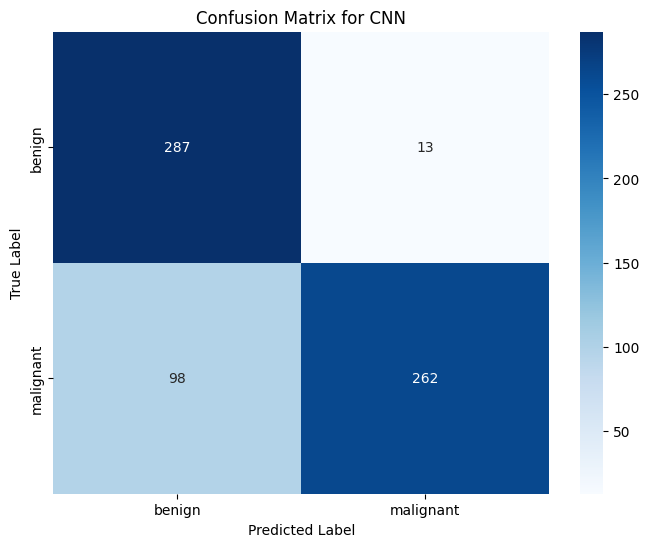

In [78]:
cnn_cm=test_and_plot_confusion_matrix(model_cnn, test_loader, CFG.DEVICE,'CNN')

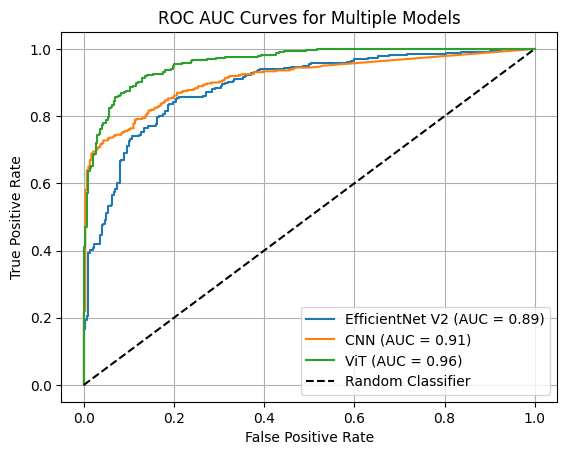

In [83]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def plot_roc_auc(models, data_loader, device):
    plt.figure()
    for model, label in models:
        model.eval()

        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)


                probabilities = torch.softmax(outputs, dim=1)[:, 1]

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(probabilities.cpu().numpy())

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)


        fpr, tpr, _ = roc_curve(all_labels, all_preds)
        roc_auc = auc(fpr, tpr)


        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    plt.title('ROC AUC Curves for Multiple Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc


models = [
    (model_efficientnet_v2_pytorch, 'EfficientNet V2'),
    (model_cnn, 'CNN'),
    (model_vit , 'ViT')


]

# Call the function to plot ROC AUC curves for all models
roc_auc_score = plot_roc_auc(models, test_loader, CFG.DEVICE)
